# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

0.post4518.dev0+g3a78bf2
2.9.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
ict_off = True
ecc_off = False

%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7726
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=-0.0
Ctrl: 0=7897; 1=6580; 
EVA: Load A from Aest.csv.
Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.3173 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1189 seconds.
System internal structure set up in 0.0754 seconds.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


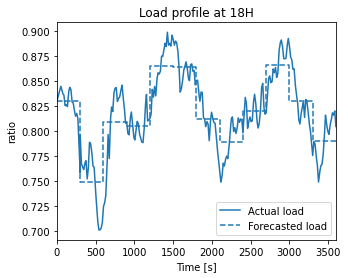

In [3]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [4]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1871 seconds.
0: |F(x)| = 9.101680411
1: |F(x)| = 3.497456414
2: |F(x)| = 0.1830766454
3: |F(x)| = 0.0007183029104
4: |F(x)| = 1.659286886e-08
Converged in 5 iterations in 0.0102 seconds.
Power flow results are consistent. Conversion is successful.


Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0108 seconds.
0: |F(x)| = 9.101680411
1: |F(x)| = 3.497456414
2: |F(x)| = 0.1830766454
3: |F(x)| = 0.0007183029104
4: |F(x)| = 1.659286886e-08
Converged in 5 iterations in 0.0125 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


pp cost=2184.5741560778915, gb cost=4889.131241556355


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,970.0313,39.9756,15.8831,1.0,970.0312
1,646.0000,228.9208,2.2281,1.0,646.0000
2,290.0000,81.0987,-0.8653,1.0,290.0000
3,652.0000,114.2245,7.2985,1.0,652.0000
4,508.0000,137.9576,5.4672,1.0,508.0000
5,646.6875,212.0871,6.4196,1.0,646.6875
6,232.0000,55.2884,3.4379,1.0,232.0000
7,564.0000,-59.8950,13.9534,1.0,564.0000
8,865.0000,49.8766,18.9462,1.0,865.0000
9,30.0000,49.8766,18.9462,1.0,30.0000


## Prepare

### Make link table

In [5]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [6]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 900

rru, rrd, rsfr = 1.0, 1.0, 0.05

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [7]:
# %run -i 'cosim_bmain.py'

Loop

In [8]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4703.628
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0172 seconds.
0: |F(x)| = 7.905038032
1: |F(x)| = 3.815590932
2: |F(x)| = 0.2217099894
3: |F(x)| = 0.001778348784
4: |F(x)| = 7.760537057e-08
Converged in 5 iterations in 0.0153 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for

Simulation to t=124.00 sec completed in 0.0906 seconds.
Simulation to t=125.00 sec completed in 0.0788 seconds.
Simulation to t=126.00 sec completed in 0.0750 seconds.
Simulation to t=127.00 sec completed in 0.0705 seconds.
Simulation to t=128.00 sec completed in 0.0749 seconds.
Simulation to t=129.00 sec completed in 0.0734 seconds.
Simulation to t=130.00 sec completed in 0.0711 seconds.
Simulation to t=131.00 sec completed in 0.0714 seconds.
Simulation to t=132.00 sec completed in 0.0753 seconds.
Simulation to t=133.00 sec completed in 0.0759 seconds.
Simulation to t=134.00 sec completed in 0.0746 seconds.
Simulation to t=135.00 sec completed in 0.0743 seconds.
Simulation to t=136.00 sec completed in 0.0771 seconds.
Simulation to t=137.00 sec completed in 0.0800 seconds.
Simulation to t=138.00 sec completed in 0.0745 seconds.
Simulation to t=139.00 sec completed in 0.0781 seconds.
Simulation to t=140.00 sec completed in 0.0796 seconds.
Simulation to t=141.00 sec completed in 0.0726 s

Simulation to t=271.00 sec completed in 0.0904 seconds.
Simulation to t=272.00 sec completed in 0.0868 seconds.
Simulation to t=273.00 sec completed in 0.0887 seconds.
Simulation to t=274.00 sec completed in 0.0808 seconds.
Simulation to t=275.00 sec completed in 0.0889 seconds.
Simulation to t=276.00 sec completed in 0.1088 seconds.
Simulation to t=277.00 sec completed in 0.1006 seconds.
Simulation to t=278.00 sec completed in 0.0940 seconds.
Simulation to t=279.00 sec completed in 0.0864 seconds.
Simulation to t=280.00 sec completed in 0.1036 seconds.
Simulation to t=281.00 sec completed in 0.1070 seconds.
Simulation to t=282.00 sec completed in 0.0980 seconds.
Simulation to t=283.00 sec completed in 0.0871 seconds.
Simulation to t=284.00 sec completed in 0.1040 seconds.
Simulation to t=285.00 sec completed in 0.1099 seconds.
Simulation to t=286.00 sec completed in 0.1038 seconds.
Simulation to t=287.00 sec completed in 0.0968 seconds.
Simulation to t=288.00 sec completed in 0.1073 s

Simulation to t=417.00 sec completed in 0.1071 seconds.
Simulation to t=418.00 sec completed in 0.1076 seconds.
Simulation to t=419.00 sec completed in 0.1034 seconds.
Simulation to t=420.00 sec completed in 0.1044 seconds.
Simulation to t=421.00 sec completed in 0.1063 seconds.
Simulation to t=422.00 sec completed in 0.1005 seconds.
Simulation to t=423.00 sec completed in 0.1022 seconds.
Simulation to t=424.00 sec completed in 0.1036 seconds.
Simulation to t=425.00 sec completed in 0.1067 seconds.
Simulation to t=426.00 sec completed in 0.1080 seconds.
Simulation to t=427.00 sec completed in 0.1052 seconds.
Simulation to t=428.00 sec completed in 0.1036 seconds.
Simulation to t=429.00 sec completed in 0.1012 seconds.
Simulation to t=430.00 sec completed in 0.1006 seconds.
Simulation to t=431.00 sec completed in 0.0996 seconds.
Simulation to t=432.00 sec completed in 0.1054 seconds.
Simulation to t=433.00 sec completed in 0.1039 seconds.
Simulation to t=434.00 sec completed in 0.1004 s

Simulation to t=564.00 sec completed in 0.0791 seconds.
Simulation to t=565.00 sec completed in 0.0750 seconds.
Simulation to t=566.00 sec completed in 0.0757 seconds.
Simulation to t=567.00 sec completed in 0.0760 seconds.
Simulation to t=568.00 sec completed in 0.0849 seconds.
Simulation to t=569.00 sec completed in 0.0751 seconds.
Simulation to t=570.00 sec completed in 0.0831 seconds.
Simulation to t=571.00 sec completed in 0.0804 seconds.
Simulation to t=572.00 sec completed in 0.0872 seconds.
Simulation to t=573.00 sec completed in 0.0809 seconds.
Simulation to t=574.00 sec completed in 0.0785 seconds.
Simulation to t=575.00 sec completed in 0.0767 seconds.
Simulation to t=576.00 sec completed in 0.0750 seconds.
Simulation to t=577.00 sec completed in 0.0775 seconds.
Simulation to t=578.00 sec completed in 0.0751 seconds.
Simulation to t=579.00 sec completed in 0.0776 seconds.
Simulation to t=580.00 sec completed in 0.0929 seconds.
Simulation to t=581.00 sec completed in 0.0812 s

Simulation to t=710.00 sec completed in 0.0872 seconds.
Simulation to t=711.00 sec completed in 0.0762 seconds.
Simulation to t=712.00 sec completed in 0.0824 seconds.
Simulation to t=713.00 sec completed in 0.0973 seconds.
Simulation to t=714.00 sec completed in 0.0794 seconds.
Simulation to t=715.00 sec completed in 0.0775 seconds.
Simulation to t=716.00 sec completed in 0.0795 seconds.
Simulation to t=717.00 sec completed in 0.0816 seconds.
Simulation to t=718.00 sec completed in 0.0750 seconds.
Simulation to t=719.00 sec completed in 0.0756 seconds.
Simulation to t=720.00 sec completed in 0.0743 seconds.
Simulation to t=721.00 sec completed in 0.0810 seconds.
Simulation to t=722.00 sec completed in 0.0794 seconds.
Simulation to t=723.00 sec completed in 0.0824 seconds.
Simulation to t=724.00 sec completed in 0.0984 seconds.
Simulation to t=725.00 sec completed in 0.0841 seconds.
Simulation to t=726.00 sec completed in 0.0752 seconds.
Simulation to t=727.00 sec completed in 0.0764 s

Simulation to t=857.00 sec completed in 0.1056 seconds.
Simulation to t=858.00 sec completed in 0.1007 seconds.
Simulation to t=859.00 sec completed in 0.0951 seconds.
Simulation to t=860.00 sec completed in 0.1055 seconds.
Simulation to t=861.00 sec completed in 0.0983 seconds.
Simulation to t=862.00 sec completed in 0.0999 seconds.
Simulation to t=863.00 sec completed in 0.0923 seconds.
Simulation to t=864.00 sec completed in 0.1046 seconds.
Simulation to t=865.00 sec completed in 0.1081 seconds.
Simulation to t=866.00 sec completed in 0.1021 seconds.
Simulation to t=867.00 sec completed in 0.0852 seconds.
Simulation to t=868.00 sec completed in 0.1005 seconds.
Simulation to t=869.00 sec completed in 0.1018 seconds.
Simulation to t=870.00 sec completed in 0.1013 seconds.
Simulation to t=871.00 sec completed in 0.0795 seconds.
Simulation to t=872.00 sec completed in 0.1049 seconds.
Simulation to t=873.00 sec completed in 0.0731 seconds.
Simulation to t=874.00 sec completed in 0.0743 s

In [9]:
ssa.exit_code

0

(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

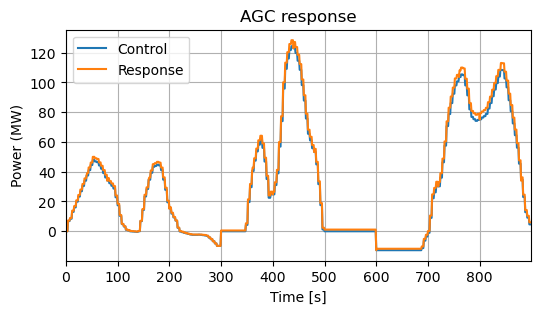

In [10]:
sse.plot_agc()

In [18]:
5.364171*0.915721* 900 / 3600 / 23.934017

0.05130860432132015

In [17]:
evc = sse.ev.copy()
evc["dna"] = evc["na"] - evc["na0"]
# evc["dna"].hist()
evc[["u", "c", "Pc", "nc", "Q", "soc0", "soc", "na0", "na", "nam", "dna"]][evc["dna"]!=0]

,u,c,Pc,nc,Q,soc0,soc,na0,na,nam,dna
0,1,1,5.364171,0.915721,23.934017,0.712835,0.755421,1910,1915,3358,5
1,1,1,5.038980,0.896479,27.430770,0.658368,0.694003,1829,1834,2879,5
2,1,1,5.953512,0.894700,27.565055,0.367779,0.407017,2131,2134,2897,3
3,1,0,6.322326,0.901444,27.018238,0.798007,0.833340,1941,1945,2977,4
6,1,1,6.538113,0.946036,27.256818,0.497114,0.544958,2124,2129,2952,5
...,...,...,...,...,...,...,...,...,...,...,...
17361,1,1,5.924089,0.880853,29.646625,0.507708,0.544818,2047,2052,2623,5
17362,1,1,5.608430,0.881180,26.294158,0.745187,0.784396,1885,1891,3056,6
17365,1,1,5.557827,0.931454,21.866444,0.381853,0.438607,2108,2110,3635,2
17368,1,1,6.940892,0.917610,21.754871,0.423124,0.484117,2224,2229,3694,5


<AxesSubplot:>

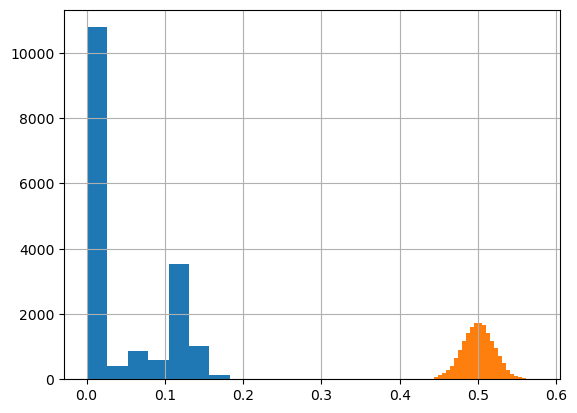

In [12]:
sse.ict2(scaler=1)
sse.ev["ict"].hist()
sse.ev["tt"].hist(bins=30)

/tmp/ipykernel_3011261/3484866467.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{np.round(i*100,0)}\%' for i in np.arange(0, 1.1, 0.2)])


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (12).

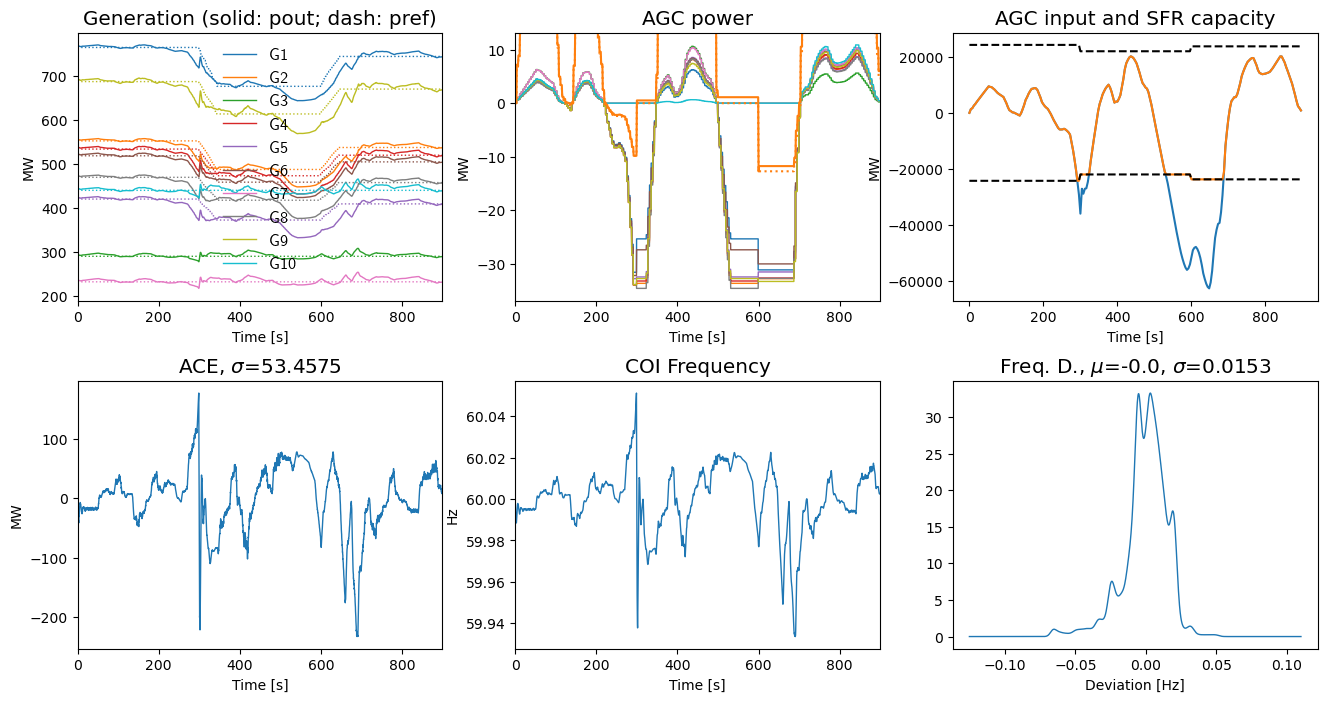

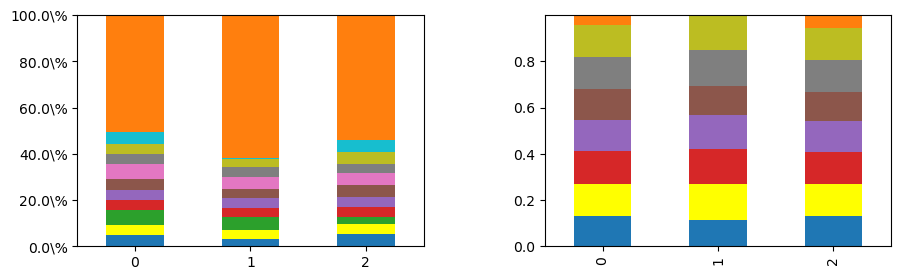

In [13]:
right = end_time

# data format conversion
ev_soc = pd.DataFrame(ev_soc_data.T, columns=range(t_total))
ev_agc = pd.DataFrame(ev_agc_data.T, columns=range(t_total))
sfr_res = pd.DataFrame(sfr_res_data, columns=['time', 'ace', 'up', 'dn', 'in'])
sfr_res['ace'] = sfr_res['ace'] * ssa.config.mva
sfr_res['up'] = sfr_res['up'] * ssa.config.mva
sfr_res['dn'] = sfr_res['dn'] * ssa.config.mva
sfr_res['in'] = sfr_res['in'] * ssa.config.mva

# data save
# Complement AGC table
agc_smooth = pd.DataFrame(np.repeat(agc_in[list(np.arange(0, t_total, 4))].values, 4, axis=1),
                          columns=list(np.arange(0, t_total, 1)))
# Record EV output
sse_out = sse.tsd.copy()

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.3)

yheader = [f'G{i}' for i in range(1, 11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                 yheader=yheader, ytimes=ssa.config.mva,
                 legend=True, show=False, right=right,
                 title=r'Generation (solid: pout; dash: pref)',
                 ylabel='MW',
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref, ytimes=ssa.config.mva,
                 legend=False, show=False, right=right,
                 linestyles=[':'],
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                 linestyles=['-'],
                 yheader=yheader, ytimes=ssa.config.mva,
                 legend=False, show=False, right=right,
                 title=r'AGC power', ylabel='MW',
                 fig=fig_gen, ax=ax_gen[0, 1])

# Plot EV AGC response, hard code
ax_gen[0, 1].plot(3600*(np.array(sse.tsd['ts'])-caseH), sse.tsd['Pr'], color='tab:orange', linestyle=':')
ax_gen[0, 1].plot(3600*(np.array(sse.tsd['ts'])-caseH), sse.tsd['Prc'], color='tab:orange', linestyle='-')
# ax_gen[0, 1].set_ylim(top=max(1.2 * max(sse.Prl), ax_gen[0, 1].get_ylim()))

ax_gen[0, 2].plot(sfr_res.time,
                  ssa.config.mva * sfr_res['ace'],
                  label='AGC raw')
ax_gen[0, 2].plot(sfr_res.time, 
                  ssa.config.mva * sfr_res['in'],
                  label='AGC input')
ax_gen[0, 2].plot(sfr_res.time,
                  ssa.config.mva * sfr_res['up'],
                  label='SFR capacity',
                  linestyle='--', color='k')
ax_gen[0, 2].plot(sfr_res.time, 
                  ssa.config.mva * sfr_res['dn'],
                  linestyle='--', color='k')
ax_gen[0, 2].set_ylabel('MW')
ax_gen[0, 2].set_xlabel('Time [s]')
ax_gen[0, 2].set_title('AGC input and SFR capacity')

aced = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1) * ssa.config.mva
ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'], ytimes=ssa.config.mva,
                 title=f'ACE, $\sigma$={aced.std().round(4)}', ylabel='MW',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'], ylabel='Hz',
                 ytimes=ssa.config.freq,
                 title=r'COI Frequency',
                 fig=fig_gen, ax=ax_gen[1, 1])

f_coi = pd.DataFrame()
f_coi['f'] = ssa.dae.ts.y[:, ssa.COI.omega.a].reshape(-1).copy() * ssa.config.freq - ssa.config.freq
f_coi.plot(kind='kde', legend=False, linewidth=1,
           fig=fig_gen, ax=ax_gen[1, 2],
           title=f'Freq. D., $\mu$={f_coi.f.mean().round(4)}, $\sigma$={f_coi.f.std().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [Hz]', ylabel='')

# --- plot bu, bd ---
# --- collect data ---
irry = np.array(-1 * np.ones((n_ed, ssd.gen.shape[0])))
bu = irry.copy()
bd = irry.copy()
pg = irry.copy()
for rted_idx in rted_res.keys():
    bu[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['bu'].values
    bd[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['bd'].values
    pg[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['pg'].values
col = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['gen']
bu_df = pd.DataFrame(bu, columns=col)
bd_df = pd.DataFrame(bd, columns=col)
pg_df = pd.DataFrame(pg, columns=col)

import matplotlib.font_manager
plt.style.use('default')

color = ['tab:blue', 'yellow', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
         'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:orange']

figs, axes = plt.subplots(1, 2, figsize=(10.5, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.35, hspace=None)
new_cols = ['PV_1', 'PV_2', 'PV_3', 'PV_4', 'PV_5', 'PV_6',
            'PV_7', 'PV_8', 'PV_9', 'Slack_10', 'PV_10']
bu_df[new_cols].plot.bar(stacked=True, ax=axes[0], legend=False, color=color)
bd_df[new_cols].plot.bar(stacked=True, ax=axes[1], legend=False, color=color)

for ax in axes:
    ax.tick_params(axis='x', labelrotation = 0)
    ax.set_ylim([0, 1])
    ax.set_yticklabels([f'{np.round(i*100,0)}\%' for i in np.arange(0, 1.1, 0.2)])
    ax.set_xticklabels([i for i in range(1,13,1)])
    ax.set_xlabel('RTED interval')
axes[0].set_title('(a) Case 1: RegUp balancing factor')
axes[1].set_title('(b) Case 1: RegDn balancing factor')
lines_labels = [ax.get_legend_handles_labels() for ax in axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
line_plot = lines[0:11]
line_plot.reverse()
label_g = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'EV']
label_g.reverse()
figs.legend(line_plot, label_g, loc='center')

# --- generation cost ---
gtc = 0
for i in pg_df.index:
    c = ssd.cost.c2.values * np.power(pg_df.loc[i].values, 2) \
        + ssd.cost.c1.values * pg_df.loc[i].values \
        + ssd.cost.c1.values
    gtc += np.sum(c)

agc_out.fillna(0, inplace=True)
agc_out_sort = pd.merge(left=agc_out.rename(columns={'stg_idx':'idx'}),
                        right=ssd.cost[['idx']], on='idx', how='right')
agc_mile = pd.DataFrame(columns=list(np.arange(intv_agc, t_total, intv_agc)))
for col_id in np.arange(intv_agc, t_total, intv_agc):
    agc_mile[col_id] = np.abs(agc_out_sort[col_id] - agc_out_sort[int(col_id-intv_agc)])
agc_mile[agc_mile.columns] *= 100

# --- SFR mileage cost ---
ftc = 0
for i in agc_mile.columns:
    c = ssd.cost.c1.abs().values * agc_mile[i].values
    ftc += np.sum(c)

print(f"Total cost={np.round(gtc+ftc, 2)}")

# --- save data ---
cosim_out = pd.DataFrame()
cosim_out['Time'] = ssa.dae.ts.t
# alter the sign of ACE
cosim_out['ACE'] = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy() * ssa.config.mva * -1
cosim_out['freq'] = ssa.dae.ts.y[:, ssa.COI.omega.a].reshape(-1).copy() * ssa.config.freq
pout9 = ssa.dae.ts.y[:, ssa.TGOV1N.pout.a[2]].reshape(-1)
pref9 = ssa.dae.ts.y[:, ssa.TGOV1N.pref.a[2]].reshape(-1)
cosim_out['paux9'] = ssa.config.mva * (pout9-pref9)


In [ ]:
# ssa.TDS.save_output()

In [ ]:
%run -i 'cosim_plot.py'

In [ ]:
# plot the AGC signal

# figa, axa = plt.subplots()
# axa.plot(range(0, 3600, 4),
#          ssa.config.mva * agc_out.values[10:, 1:].reshape(900, 1),
#          color='tab:orange')
# axa.plot(range(0, 3600, 4),
#          ssa.config.mva * agc_in.values[10:, 1:].reshape(900, 1),
#          color='tab:red')
# ssa.TDS.plt.plot(ssa.TGOV1N.paux,
#                  linestyles=['-'],
#                  yheader=yheader,
#                  ytimes=ssa.config.mva,
#                  legend=False, show=False,
#                  title=r'AGC power', ylabel='MW',
#                  fig=figa, ax=axa, style='default',
#                  left=1000, right=2000)
# axa.legend(['AGC_out-EV', 'AGC_in-EV'])

In [ ]:
# sim_name = '_F'
# cosim_out.to_csv('cosim_18' + sim_name + '_out.csv', index=False)
# sse_out.to_csv('cosim_18' + sim_name + '_sse.csv', index=False)
# bu_df.to_csv('cosim_18' + sim_name + '_bu.csv', index=False)
# bd_df.to_csv('cosim_18' + sim_name + '_bd.csv', index=False)
# pg_df.to_csv('cosim_18' + sim_name + '_pg.csv', index=False)
# agc_mile.to_csv('cosim_18' + sim_name + '_agcm.csv', index=False)
# sfr_res.to_csv('cosim_18' + sim_name + '_sfr.csv', index=False)
# ev_agc.to_csv('cosim_18' + sim_name + '_evagc.csv', index=False)
# ev_soc.iloc[0:800].to_csv('cosim_18' + sim_name + '_evsoc1.csv', index=False)
# ev_soc.iloc[800:].to_csv('cosim_18' + sim_name + '_evsoc2.csv', index=False)
# sse.ev.to_csv('cosim_18' + sim_name + '_evdata.csv', index=False)

# import csv
# new_path = open('cosim_18' + sim_name + '_rted.csv', 'w')
# z = csv.writer(new_path)
# for new_k, new_v in rted_res.items():
#     z.writerow([new_k, new_v])
# new_path.close()

In [ ]:
# split -l 4 index.txt split_file
# !ls -lh

plt.style.use('science')
%run -i 'cosim_plotev.py'